In [1]:
## Step 1: Mount Google Drive (for accessing dataset and saving the model)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Step 2: Import Necessary Libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
## Step 3: Set Dataset Path from Google Drive
dataset_path = '/content/drive/MyDrive/Diseas'

In [4]:
def custom_preprocessing(image):
    # Convert to YUV color space for Histogram Equalization
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # Apply Histogram Equalization on the Y channel
    # Convert Y channel to uint8 before applying Histogram Equalization
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0].astype(np.uint8))
    # Convert back to RGB color space
    equalized_rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    # Apply Gaussian Smoothing
    smoothed = cv2.GaussianBlur(equalized_rgb, (5, 5), 0)
    return smoothed / 255.0  # Normalize to 0-1 range

In [5]:
## Step 4: Data Preprocessing
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
     preprocessing_function=custom_preprocessing,  # Custom preprocessing added here

    rotation_range=20,          # Image rotate karne ka range 20 degrees
    width_shift_range=0.2,      # Image horizontal shift
    height_shift_range=0.2,     # Image vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom transformation
    horizontal_flip=True,       # Random horizontal flip
    brightness_range=[0.8, 1.2], # Brightness adjustment
    channel_shift_range=0.1,     # Random color shift
    fill_mode='nearest',         # Filling empty pixels
    validation_split=0.2,        # 80% training, 20% validation
     #seed=42                    # Randomness control ke liye
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
     color_mode='rgb',
    subset='training',
    seed=42  # Setting seed for reproducibility in flow_from_directory
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
     color_mode='rgb',
    subset='validation',
    seed=42 # Setting seed for reproducibility in flow_from_directory
)



Found 4305 images belonging to 4 classes.
Found 1075 images belonging to 4 classes.


In [6]:
#  CNN Model
def create_cnn_model(input_shape=(150, 150, 3), num_classes=len(train_generator.class_indices)):
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),  # 50% neurons randomly drop honge
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [7]:

# Model Summary
if __name__ == "__main__":
    model = create_cnn_model()
    model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      18,940,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,033,796 (72.61 MB)

 Trainable params: 19,033,796 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 1462s 11s/step - accuracy: 0.4745 - loss: 1.4472 - val_accuracy: 0.6614 - val_loss: 0.8896
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 56s 417ms/step - accuracy: 0.6217 - loss: 0.9670 - val_accuracy: 0.7079 - val_loss: 0.7460
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 55s 410ms/step - accuracy: 0.7170 - loss: 0.7552 - val_accuracy: 0.7228 - val_loss: 0.7343
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 56s 418ms/step - accuracy: 0.7239 - loss: 0.6997 - val_accuracy: 0.8093 - val_loss: 0.5249
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 415ms/step - accuracy: 0.7609 - loss: 0.6111 - val_accuracy: 0.8205 - val_loss: 0.5124
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 487ms/step - accuracy: 0.7722 - loss: 0.5920 - val_accuracy: 0.8149 - val_loss: 0.4708
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 56s 413ms/step - accuracy: 0.8107 - loss: 0.5008 - val_accuracy: 0.8242 - val_loss: 0.4839
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 57s 421ms/step - accuracy: 0.8197 - loss: 0

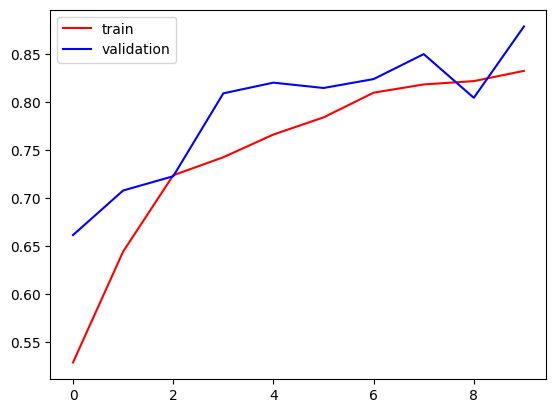

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

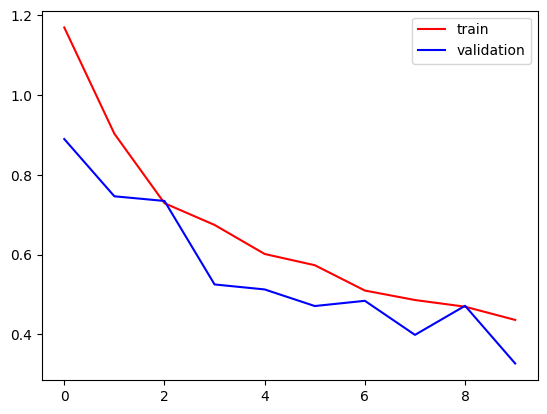

In [10]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [11]:
model.save("/content/drive/MyDrive/paddy_leaf_disease_model.keras")

In [12]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/paddy_leaf_disease_model.keras")

In [23]:
## Step 10: Make Predictions
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

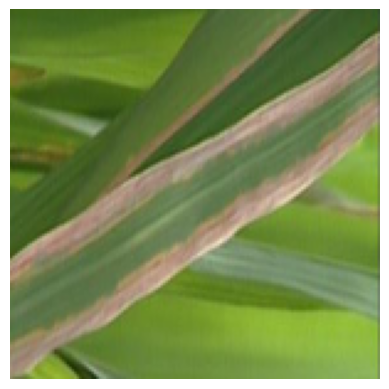

In [30]:
# Select a random image from validation set
random_image_path = random.choice(val_generator.filepaths)
img = image.load_img(random_image_path, target_size=image_size)
plt.imshow(img)
plt.axis('off')
plt.show()

In [31]:
# Preprocess the image
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

In [32]:
# Predict
y_pred = model.predict(img_array)
pred_class = np.argmax(y_pred)
print(f"Predicted Class: {list(train_generator.class_indices.keys())[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: Bacterialblight
